# Analysis of the Stackoverflow Survey of 2017

In this notebook, some analysis on the stackoverflow survey of 2017 will be done.

The analysis is done by following the steps in the table of contents. 

## Table of Contents

I.   [Data gathering](#Gathering)<br>
II.  [Data assess - Which questions should be answered?](#Assess)<br>
III. [Data cleaning](#Clean)<br>
VI.  [Data Modelling and Analysis](#Modelling)<br>

In [7]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

%matplotlib inline

from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import f1_score
from sklearn.model_selection import GridSearchCV, train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.pipeline import Pipeline

import seaborn as sns
from collections import defaultdict

## <a class="anchor" id="Gathering">Part I : Data gathering</a>

Stackoverflow performs an anual survey, this data is available [here](https://insights.stackoverflow.com/survey/). The survey covers a wide range of topics. In order to find interesting questions for the analysis of the data, the existing statements were read crosswise.

From the previous work with this data set in the udacity classes, no big explanatory analysis has been done.

In [8]:
df = pd.read_csv('../data/survey_results_public.csv')
df_schema = pd.read_csv('../data/survey_results_schema.csv')

# Show df to get an idea of the data
df.head()

,Respondent,Professional,ProgramHobby,Country,University,EmploymentStatus,FormalEducation,MajorUndergrad,HomeRemote,CompanySize,...,StackOverflowMakeMoney,Gender,HighestEducationParents,Race,SurveyLong,QuestionsInteresting,QuestionsConfusing,InterestedAnswers,Salary,ExpectedSalary
0,1,Student,"Yes, both",United States,No,"Not employed, and not looking for work",Secondary school,NaN,NaN,NaN,...,Strongly disagree,Male,High school,White or of European descent,Strongly disagree,Strongly agree,Disagree,Strongly agree,NaN,NaN
1,2,Student,"Yes, both",United Kingdom,"Yes, full-time",Employed part-time,Some college/university study without earning ...,Computer science or software engineering,"More than half, but not all, the time",20 to 99 employees,...,Strongly disagree,Male,A master's degree,White or of European descent,Somewhat agree,Somewhat agree,Disagree,Strongly agree,NaN,37500.0
2,3,Professional developer,"Yes, both",United Kingdom,No,Employed full-time,Bachelor's degree,Computer science or software engineering,"Less than half the time, but at least one day ...","10,000 or more employees",...,Disagree,Male,A professional degree,White or of European descent,Somewhat agree,Agree,Disagree,Agree,113750.0,NaN
3,4,Professional non-developer who sometimes write...,"Yes, both",United States,No,Employed full-time,Doctoral degree,A non-computer-focused engineering discipline,"Less than half the time, but at least one day ...","10,000 or more employees",...,Disagree,Male,A doctoral degree,White or of European descent,Agree,Agree,Somewhat agree,Strongly agree,NaN,NaN
4,5,Professional developer,"Yes, I program as a hobby",Switzerland,No,Employed full-time,Master's degree,Computer science or software engineering,Never,10 to 19 employees,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [9]:
df_schema.head()

,Column,Question
0,Respondent,Respondent ID number
1,Professional,Which of the following best describes you?
2,ProgramHobby,Do you program as a hobby or contribute to ope...
3,Country,In which country do you currently live?
4,University,"Are you currently enrolled in a formal, degree..."


In [10]:
assert df.shape[1] == df_schema.shape[0]
print('The survey contained {} questions. In total, there are {} survey responses.'.format(df.shape[1], df.shape[0]))

The survey contained 154 questions. In total, there are 19102 survey responses.


## <a class="anchor" id="Assess">Part II : Data assess - Which questions should be answered?</a>

The schema and the data are used to find interessting questions which should be answered in the following analysis.

In [11]:
df_schema.head(n=10)

,Column,Question
0,Respondent,Respondent ID number
1,Professional,Which of the following best describes you?
2,ProgramHobby,Do you program as a hobby or contribute to ope...
3,Country,In which country do you currently live?
4,University,"Are you currently enrolled in a formal, degree..."
5,EmploymentStatus,Which of the following best describes your cur...
6,FormalEducation,Which of the following best describes the high...
7,MajorUndergrad,Which of the following best describes your mai...
8,HomeRemote,How often do you work from home or remotely?
9,CompanySize,"In terms of the number of employees, how large..."


**Questions which will be answered in the following parts:**

|#| Question | Helpful columns |
| ---| :--- | :---|
|1| Exists a correlation between "Overpaid" and the programming experience? | YearsProgram, Overpaid |
|2| Is there a programing language specific correlation between "OtherPeoplesCode - Maintaining other people's code is a form of torture" and "EnjoyDebugging -I enjoy debugging code"?| HaveWorkedLanguage, OtherPeoplesCode, EnjoyDebugging|
|3|How many people, who program in Python, follow the PEP8 guidelines and use spaces instead of tabs?|HaveWorkedLanguage, TabsSpaces|

The questions have been found by looking at the df_schema in detail to find interesting questions.

## <a class="anchor" id="Clean">Part III: Data cleaning</a>

In [Part II](#Assess) the needed columns are defined. In the following, the data is preperaded for each question. Only the needed columns are modified and cleaned.

The column *HaveWorkedLanguage* is split into separated columns, one for each programming language. This information is needed for question 2 and 3, so it is done once at the beginning on the original data.

Here are short cuts for the different questions:
- [Question 1](#Clean-q1)
- [Question 2](#Clean-q2)
- [Question 3](#Clean-q3)

In [16]:
# HAVE WORKED LANGUAGE - Extract available values
# convert all 'HaveWorkedLanguage' entries into lists: df_q3.HaveWorkedLanguage.str.split(';')
df['HaveWorkedLanguageList'] = df.HaveWorkedLanguage.str.split(';')
#flatten all lists to one
prog_languages = set()
for entry in df.HaveWorkedLanguageList:
    if isinstance(entry, float):
        # list(entry) is empty, so NaN is returned
        continue
    else:
        [prog_languages.add(elem.strip()) for elem in entry]


In [17]:
# convert available programming languages in columns
print(df.columns)
df[list(prog_languages)] = pd.DataFrame(data = np.zeros((df.shape[0],len(prog_languages))), columns = list(prog_languages))
print(df.columns)

Index(['Respondent', 'Professional', 'ProgramHobby', 'Country', 'University',
       'EmploymentStatus', 'FormalEducation', 'MajorUndergrad', 'HomeRemote',
       'CompanySize',
       ...
       'Gender', 'HighestEducationParents', 'Race', 'SurveyLong',
       'QuestionsInteresting', 'QuestionsConfusing', 'InterestedAnswers',
       'Salary', 'ExpectedSalary', 'HaveWorkedLanguageList'],
      dtype='object', length=155)
Index(['Respondent', 'Professional', 'ProgramHobby', 'Country', 'University',
       'EmploymentStatus', 'FormalEducation', 'MajorUndergrad', 'HomeRemote',
       'CompanySize',
       ...
       'Lua', 'Swift', 'CoffeeScript', 'Visual Basic 6', 'Java', 'Assembly',
       'Objective-C', 'C', 'PHP', 'SQL'],
      dtype='object', length=190)


In [18]:
# Convert HaveWorkedList into binary values for the different programming languages
for idx, prog_lang_list in df.HaveWorkedLanguageList.iteritems():
    if isinstance(prog_lang_list, float):
        # list(entry) is empty, so NaN is returned
        continue
    else:
        for entry in prog_lang_list:
            entry = entry.strip()
            df.loc[df.index[idx], entry] = 1

In [20]:
# Pick the needed columns for each question
df_q1 = df[['YearsProgram', 'Overpaid']]
df_q2 = df[list(prog_languages)+['OtherPeoplesCode', 'EnjoyDebugging']]
df_q3 = df[['Python', 'TabsSpaces']]


### <a class="anchor" id="Clean-q1">Data cleaning for question 1: Exists a correlation between "Overpaid" and the programming experience?</a>

In [21]:
# Calculation makes only sense if a value for *Overpaid* is available
df_q1 = df_q1.dropna(subset = ['Overpaid'])
print('The number of survey responsdents reduced from {} to {}.'.format(df.shape[0], df_q1.shape[0]))

The number of survey responsdents reduced from 19102 to 5184.


In [22]:
## YEARS PROGRAM
# Create a nested dictionary which matches the years of experience with the overpaid rate
q1_dict_experience = defaultdict(dict)

for key, data in df_q1.groupby(by=['YearsProgram', 'Overpaid']):
    experience = key[0]
    overpaid_target = key[1]
    value = data.YearsProgram.count()
    q1_dict_experience[experience][overpaid_target] = value
    
print(q1_dict_experience)

defaultdict(<class 'dict'>, {'1 to 2 years': {'Greatly underpaid': 17, 'Neither underpaid nor overpaid': 31, 'Somewhat overpaid': 4, 'Somewhat underpaid': 31}, '10 to 11 years': {'Greatly overpaid': 2, 'Greatly underpaid': 34, 'Neither underpaid nor overpaid': 113, 'Somewhat overpaid': 20, 'Somewhat underpaid': 135}, '11 to 12 years': {'Greatly overpaid': 1, 'Greatly underpaid': 21, 'Neither underpaid nor overpaid': 72, 'Somewhat overpaid': 9, 'Somewhat underpaid': 95}, '12 to 13 years': {'Greatly overpaid': 1, 'Greatly underpaid': 17, 'Neither underpaid nor overpaid': 69, 'Somewhat overpaid': 13, 'Somewhat underpaid': 92}, '13 to 14 years': {'Greatly underpaid': 14, 'Neither underpaid nor overpaid': 68, 'Somewhat overpaid': 14, 'Somewhat underpaid': 60}, '14 to 15 years': {'Greatly overpaid': 3, 'Greatly underpaid': 21, 'Neither underpaid nor overpaid': 96, 'Somewhat overpaid': 13, 'Somewhat underpaid': 128}, '15 to 16 years': {'Greatly overpaid': 1, 'Greatly underpaid': 23, 'Neither 

### <a class="anchor" id="Clean-q2">Cleaning for question 2: Is there a programing language specific correlation between "OtherPeoplesCode - Maintaining other people's code is a form of torture" and "EnjoyDebugging -I enjoy debugging code"? </a>

In [28]:
# Calculation makes only sense if both values 'OtherPeoplesCode' and 'EnjoyDebugging' are available
df_q2 = df_q2.dropna(subset = ['EnjoyDebugging', 'OtherPeoplesCode'], how = 'any')
#df_q2 = df_q2.reset_index(drop = True)
print('The number of survey responsdents reduced from {} to {}.'.format(df.shape[0], df_q2.shape[0]))

The number of survey responsdents reduced from 19102 to 11148.


In [29]:
# OTHER PEOPLE CODE
tmp = pd.get_dummies(df_q2.OtherPeoplesCode, prefix='OtherPeoplesCode', prefix_sep='_')
df_q2[tmp.columns] = tmp
df_q2 = df_q2.drop(labels=['OtherPeoplesCode'], axis = 1)

In [30]:
# ENJOY DEBUGGING
tmp = pd.get_dummies(df_q2.EnjoyDebugging, prefix='EnjoyDebugging', prefix_sep='_')
df_q2[tmp.columns] = tmp
df_q2 = df_q2.drop(labels=['EnjoyDebugging'], axis = 1)

In [31]:
df_q2.head()

,Python,Go,Smalltalk,Elixir,VBA,Clojure,Common Lisp,TypeScript,Matlab,C++,...,OtherPeoplesCode_Agree,OtherPeoplesCode_Disagree,OtherPeoplesCode_Somewhat agree,OtherPeoplesCode_Strongly agree,OtherPeoplesCode_Strongly disagree,EnjoyDebugging_Agree,EnjoyDebugging_Disagree,EnjoyDebugging_Somewhat agree,EnjoyDebugging_Strongly agree,EnjoyDebugging_Strongly disagree
1,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0,1,0,0,0,1,0,0,0,0
2,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0,1,0,0,0,1,0,0,0,0
3,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,...,1,0,0,0,0,0,0,1,0,0
7,1.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,...,0,0,1,0,0,1,0,0,0,0
8,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0,0,1,0,0,1,0,0,0,0


### <a class="anchor" id="Clean-q3">Cleaning for question 3: How many people, who program in Python, follow the PEP8 guidelines and use spaces instead of tabs? </a>



In [32]:
# Extract only the people who programm in Python
print(df_q3.head())
df_q3 = df_q3[df_q3.Python == 1]
print(df_q3.head())

   Python TabsSpaces
0     0.0       Tabs
1     1.0     Spaces
2     1.0     Spaces
3     1.0     Spaces
4     0.0        NaN
   Python TabsSpaces
1     1.0     Spaces
2     1.0     Spaces
3     1.0     Spaces
6     1.0     Spaces
7     1.0     Spaces


In [33]:
# TABS SPACES
tmp = pd.get_dummies(df_q3.TabsSpaces, prefix='TabsSpaces', prefix_sep='_')
#print(tmp.shape)
df_q3[tmp.columns] = tmp
#print(df_q1.shape)
df_q3 = df_q3.drop(labels=['TabsSpaces'], axis = 1)

### <a class="anchor" id="Modelling">Part VI: Data Modelling and Analysis</a>

Here are short cuts for the different questions:
- [Question 1](#Model-q1)
- [Question 2](#Model-q2)
- [Question 3](#Model-q3)

### <a class="anchor" id="Model-q1">Analysis for question 1: Exists a correlation between *Overpaid* and the programming experience? </a>

In [23]:
df_q1.head()

,YearsProgram,Overpaid
2,20 or more years,Neither underpaid nor overpaid
8,13 to 14 years,Neither underpaid nor overpaid
14,20 or more years,Somewhat underpaid
17,20 or more years,Neither underpaid nor overpaid
18,2 to 3 years,Somewhat overpaid


In [24]:
# To get comparable values, the values have to be set into relation to the total entries in this YearsProgram value
for key1, elem in df_q1.groupby(by=['YearsProgram'])['Overpaid']:
    for key2 in q1_dict_experience[key1]:
        q1_dict_experience[key1][key2] = (q1_dict_experience[key1][key2]/elem.count())*100

In [25]:
key2 = 'Greatly underpaid'
greatly_underpaid = [q1_dict_experience[key1][key2] if key2 in q1_dict_experience[key1].keys() else 0 for key1 in q1_dict_experience.keys()]
key2 = 'Somewhat underpaid'
underpaid = [q1_dict_experience[key1][key2] if key2 in q1_dict_experience[key1].keys() else 0 for key1 in q1_dict_experience.keys()]
key2 = 'Neither underpaid nor overpaid'
neither = [q1_dict_experience[key1][key2] if key2 in q1_dict_experience[key1].keys() else 0 for key1 in q1_dict_experience.keys()]
key2 = 'Somewhat overpaid'
overpaid = [q1_dict_experience[key1][key2] if key2 in q1_dict_experience[key1].keys() else 0 for key1 in q1_dict_experience.keys()]
key2 = 'Greatly overpaid'
greatly_overpaid = [q1_dict_experience[key1][key2] if key2 in q1_dict_experience[key1].keys() else 0 for key1 in q1_dict_experience.keys()]

In [26]:
bottom_p3 = [x + y for x, y in zip(underpaid, greatly_underpaid)]
bottom_p4 = [x + y for x, y in zip(bottom_p3, neither)]
bottom_p5 = [x + y for x, y in zip(bottom_p4, overpaid)]

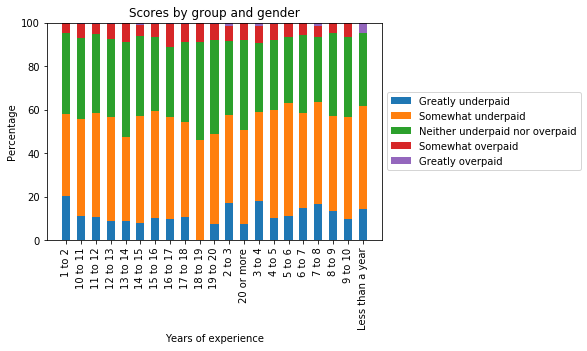

In [27]:
N = len(greatly_overpaid)
ind = np.arange(N)    # the x locations for the groups
width = 0.55       # the width of the bars: can also be len(x) sequence

p1 = plt.bar(ind, greatly_underpaid, width)
p2 = plt.bar(ind, underpaid, width,
             bottom=greatly_underpaid)
p3 = plt.bar(ind, neither, width,
             bottom=bottom_p3)
p4 = plt.bar(ind, overpaid, width,
             bottom=bottom_p4)
p5 = plt.bar(ind, greatly_overpaid, width,
             bottom=bottom_p5)

plot_xticks = [elem.split(' years')[0] for elem in list(q1_dict_experience.keys())]

plt.ylabel('Percentage')
plt.title('Scores by group and gender')
plt.xticks(ind, plot_xticks, rotation='vertical')#('0-5', '5-10', '10-15', '15+'))
plt.xlabel('Years of experience')
#plt.yticks(np.arange(0, 81, 10))
plt.legend((p1[0], p2[0], p3[0], p4[0], p5[0]), 
           ('Greatly underpaid', 'Somewhat underpaid', 'Neither underpaid nor overpaid', 'Somewhat overpaid', 'Greatly overpaid'),loc='center left', bbox_to_anchor=(1, 0.5))

plt.show()

### <a class="anchor" id="Model-q2"> Analysis for question 2: Is there a programing language specific correlation between "OtherPeoplesCode - Maintaining other people's code is a form of torture" and "EnjoyDebugging -I enjoy debugging code"?</a>

In [34]:
df_q2.head()

,Python,Go,Smalltalk,Elixir,VBA,Clojure,Common Lisp,TypeScript,Matlab,C++,...,OtherPeoplesCode_Agree,OtherPeoplesCode_Disagree,OtherPeoplesCode_Somewhat agree,OtherPeoplesCode_Strongly agree,OtherPeoplesCode_Strongly disagree,EnjoyDebugging_Agree,EnjoyDebugging_Disagree,EnjoyDebugging_Somewhat agree,EnjoyDebugging_Strongly agree,EnjoyDebugging_Strongly disagree
1,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0,1,0,0,0,1,0,0,0,0
2,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0,1,0,0,0,1,0,0,0,0
3,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,...,1,0,0,0,0,0,0,1,0,0
7,1.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,...,0,0,1,0,0,1,0,0,0,0
8,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0,0,1,0,0,1,0,0,0,0


In [35]:
target_columns = [elem for elem in df_q2.columns if elem not in list(prog_languages)]
print(target_columns)

['OtherPeoplesCode_Agree', 'OtherPeoplesCode_Disagree', 'OtherPeoplesCode_Somewhat agree', 'OtherPeoplesCode_Strongly agree', 'OtherPeoplesCode_Strongly disagree', 'EnjoyDebugging_Agree', 'EnjoyDebugging_Disagree', 'EnjoyDebugging_Somewhat agree', 'EnjoyDebugging_Strongly agree', 'EnjoyDebugging_Strongly disagree']


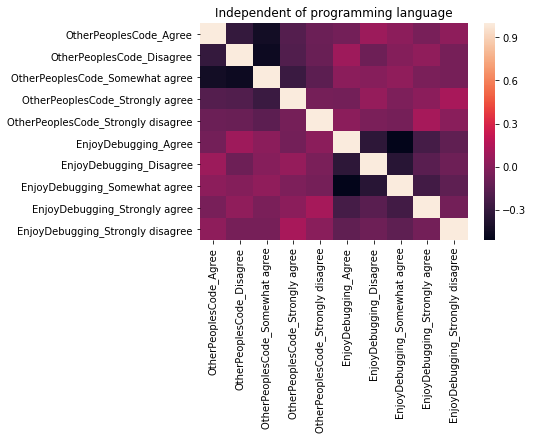

In [36]:
corr_df_q2 = df_q2[target_columns]
#print(corr_df_q2)

corr = corr_df_q2.corr()
#print(corr)
plt.title('Independent of programming language')
sns.heatmap(corr, 
            xticklabels=corr.columns.values,
            yticklabels=corr.columns.values)

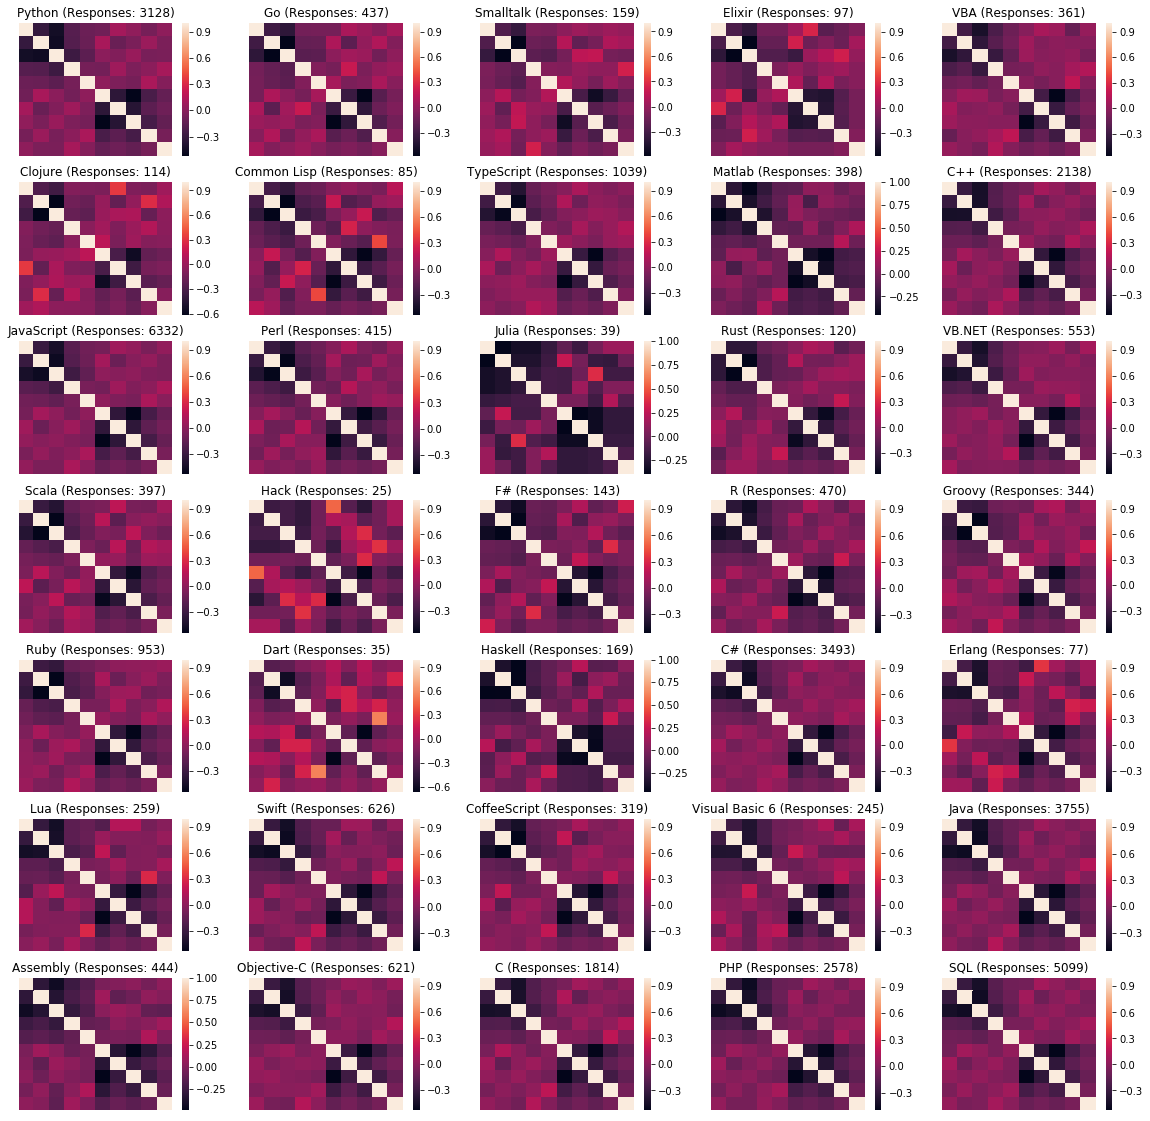

In [37]:
# Organizing plots
fig, axs = plt.subplots(7,5, figsize=(20, 20), facecolor='w', edgecolor='k')
#axs = axs.ravel()
#print(target_columns)
#

for idx, language in enumerate(prog_languages):
    # Only users who use this language are regarded
    tmp = df_q2[df_q2[language] == 1]
    #print(tmp)
    corr_df_q2 = tmp[target_columns]
    corr = corr_df_q2.corr()
    
    
    plt.subplot(7,5,idx+1) 
    # https://jakevdp.github.io/PythonDataScienceHandbook/04.08-multiple-subplots.html#plt.subplot:-Simple-Grids-of-Subplots
    plt.title(language + ' (Responses: '+str(tmp.shape[0])+')')
    sns.heatmap(corr, xticklabels=[], yticklabels=[])


### <a class="anchor" id="Model-q3">Analysis for question 3: How many people, who program in Python, follow the PEP8 guidlines and use spaces instead of tabs?</a>

In [38]:
df_q3.head()

,Python,TabsSpaces_Both,TabsSpaces_Spaces,TabsSpaces_Tabs
1,1.0,0,1,0
2,1.0,0,1,0
3,1.0,0,1,0
6,1.0,0,1,0
7,1.0,0,1,0


This question aims at a percentage, not a prediction. Therefore, no attempt to apply a machine learning model was made.

In [40]:
sum_spaces = df_q3.TabsSpaces_Spaces.sum()
sum_tabs = df_q3.TabsSpaces_Tabs.sum()
sum_both = df_q3.TabsSpaces_Both.sum()
print('{} Stackoverflow users who programm in Python use Spaces, '
      'as it is suggested by the PEP8 guidelines. This are {:.2f}% of all python users in this survey.'
      .format(sum_spaces, (sum_spaces/df_q3.shape[0])*100))


print('{} of the survey participants which programm in Python have not '
      'heard about PEP8 yet and use tabs for indentation. This are {:.2f}%. Hopefully this number will decrease.'
      .format(sum_tabs,(sum_tabs/df_q3.shape[0])*100))

print('Only {:.2f}% of the Python programmers write a mixture of tabs and spaces. If they are only programming '
      'Python, this means that they use Python 2, because Python 3 does not allow '
      'a mixing of tabs and spaces anymore.'
      .format((sum_both/df_q3.shape[0])*100))

2119 Stackoverflow users who programm in Python use Spaces, as it is suggested by the PEP8 guidelines. This are 50.46% of all python users in this survey.
1457 of the survey participants which programm in Python have not heard about PEP8 yet and use tabs for indentation. This are 34.70% Hopefully this number will decrease.
Only 14.57% of the Python programmers write a mixture of tabs and spaces. If they are only programming Python, this means that they use Python 2, because Python 3 does not allow a mixing of tabs and spaces anymore.
